In [5]:
pip install tensorflow


  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.70.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached h5py-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorflow_io_gcs_filesystem-0.37.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Us

In [9]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

2025-03-06 15:40:44.362429: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 15:40:44.372500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:40:44.454529: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:40:44.537372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741255844.620702   80563 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741255844.64

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tenet/.netrc
wandb: Currently logged in as: vinyk-sd (vinyk-sd-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
wandb.init(project="fashion-mnist-nn", entity = "vinyk-sd")

In [10]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape data
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


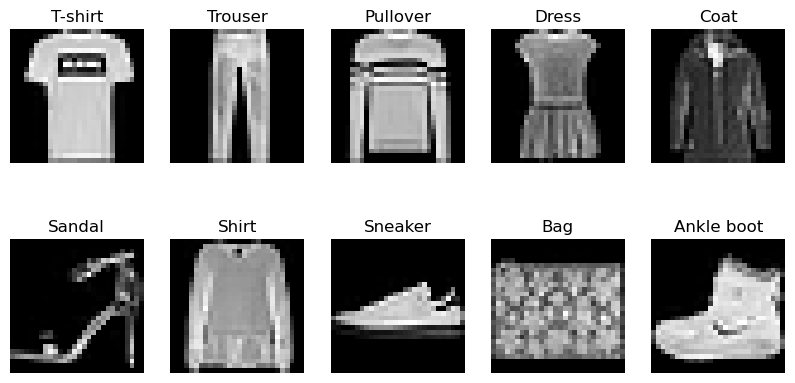

In [11]:
# Display one sample per class
classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    sample_idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[sample_idx].reshape(28, 28), cmap="gray")
    ax.set_title(classes[i])
    ax.axis("off")
plt.show()

# Log images to wandb
wandb.log({"Fashion-MNIST Samples": [wandb.Image(X_train[np.where(y_train == i)[0][0]].reshape(28, 28), caption=classes[i]) for i in range(10)]})

In [12]:
# Activation Functions
def sigmoid(x, derivative=False):
    sig = 1 / (1 + np.exp(-x))
    return sig * (1 - sig) if derivative else sig

def tanh(x, derivative=False):
    t = np.tanh(x)
    return 1 - t**2 if derivative else t

def relu(x, derivative=False):
    return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)


# Weight Initialization
def init_weights(layers, method="random"):
    np.random.seed(42)
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        if method == "Xavier":
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
            w = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
        else:
            w = np.random.randn(layers[i], layers[i+1]) * 0.01
        b = np.zeros((1, layers[i+1]))
        weights.append(w)
        biases.append(b)
    return weights, biases


# Forward Propagation
def forward_propagation(X, weights, biases, activation="relu"):
    activations = [X]
    zs = []
    for w, b in zip(weights, biases):
        z = np.dot(activations[-1], w) + b
        zs.append(z)
        activations.append(
            relu(z) if activation == "relu" else tanh(z) if activation == "tanh" else sigmoid(z)
        )
    return activations, zs


# Backpropagation
def backward_propagation(y_true, activations, zs, weights, learning_rate, activation="relu"):
    grads_w, grads_b = [], []
    m = y_true.shape[0]
    
    # Compute loss gradient
    dA = activations[-1] - y_true  # Cross-entropy derivative
    
    for i in reversed(range(len(weights))):
        dz = dA * (
            relu(zs[i], derivative=True) if activation == "relu" else 
            tanh(zs[i], derivative=True) if activation == "tanh" else 
            sigmoid(zs[i], derivative=True)
        )
        dw = np.dot(activations[i].T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        dA = np.dot(dz, weights[i].T)
        
        grads_w.insert(0, dw)
        grads_b.insert(0, db)
    
    return grads_w, grads_b


# Optimizers
class Optimizer:
    def __init__(self, method="sgd", lr=0.01, beta=0.9, beta2=0.999, epsilon=1e-8):
        self.method = method
        self.lr = lr
        self.beta = beta
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def update(self, weights, biases, grads_w, grads_b):
        if self.method == "sgd":
            return [w - self.lr * dw for w, dw in zip(weights, grads_w)], \
                   [b - self.lr * db for b, db in zip(biases, grads_b)]
        
        if self.method in ["momentum", "nesterov"]:
            if self.m is None:
                self.m = [np.zeros_like(w) for w in weights]
            
            for i in range(len(weights)):
                self.m[i] = self.beta * self.m[i] + self.lr * grads_w[i]
                weights[i] -= self.m[i] if self.method == "momentum" else self.beta * self.m[i] + self.lr * grads_w[i]

        if self.method in ["adam", "nadam", "rmsprop"]:
            if self.m is None:
                self.m = [np.zeros_like(w) for w in weights]
                self.v = [np.zeros_like(w) for w in weights]
            
            self.t += 1
            for i in range(len(weights)):
                self.m[i] = self.beta * self.m[i] + (1 - self.beta) * grads_w[i]
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grads_w[i] ** 2)
                m_hat = self.m[i] / (1 - self.beta**self.t)
                v_hat = self.v[i] / (1 - self.beta2**self.t)
                weights[i] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return weights, biases


# Training
def train(X, y, layers, epochs=10, batch_size=32, optimizer="sgd", activation="relu"):
    weights, biases = init_weights(layers)
    opt = Optimizer(method=optimizer, lr=0.001)

    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            activations, zs = forward_propagation(X_batch, weights, biases, activation)
            grads_w, grads_b = backward_propagation(y_batch, activations, zs, weights, 0.001, activation)
            weights, biases = opt.update(weights, biases, grads_w, grads_b)

        # Logging to wandb
        loss = np.mean(-y_batch * np.log(activations[-1] + 1e-8))  # Cross-entropy
        wandb.log({"epoch": epoch + 1, "loss": loss})
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

In [13]:
# Run training
train(X_train, y_train_one_hot, layers=[784, 128, 64, 10], epochs=10, optimizer="adam", activation="relu")

Epoch 1/10, Loss: 0.1443
Epoch 2/10, Loss: 0.0555
Epoch 3/10, Loss: 0.0379
Epoch 4/10, Loss: 0.0345
Epoch 5/10, Loss: 0.0315
Epoch 6/10, Loss: 0.0321
Epoch 7/10, Loss: 0.0342
Epoch 8/10, Loss: 0.0256
Epoch 9/10, Loss: 0.0768
Epoch 10/10, Loss: 0.0264
